TROPICAL TRENDSETTERS
Robin Mikeal and Jef Hinton
NOTES:
CLEAN DATA PREPARED IN LAST SUBMISSION
DATA SELECTED ONLY FROM THE TAMPA RADIUS

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("GEO557Tropical_Storm_Dataset_CLEAN.csv") 
# import, get info and head to prove data exists. 
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      2240 non-null   int64  
 1   Name      2240 non-null   object 
 2   BASIN     0 non-null      float64
 3   ISO_TIME  2240 non-null   object 
 4   NATURE    2240 non-null   object 
 5   LAT       2240 non-null   float64
 6   LON       2240 non-null   float64
 7   WMO WIND  1180 non-null   float64
 8   WMO PRES  1180 non-null   float64
 9   USA WIND  2240 non-null   int64  
 10  USA PRES  2240 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 192.6+ KB
None


Year    Name  BASIN             ISO_TIME NATURE   LAT   LON  WMO WIND  \
0  2023  IDALIA    NaN  2023-08-26 12:00:00     TS  20.8 -86.1      25.0   
1  2023  IDALIA    NaN  2023-08-26 15:00:00     TS  21.1 -86.1       NaN   
2  2023  IDALIA    NaN  2023-08-26 18:00:00     TS  21.3 -86.2      25.0   
3  2023  IDALIA    NaN  2023-08-26 21:00:00     TS  21.3 -86.3       NaN   
4  2023  IDALIA    NaN  2023-08-27 00:00:00     TS  21.1 -86.4      30.0   
5  2023  IDALIA    NaN  2023-08-27 03:00:00     TS  20.8 -86.7       NaN   
6  2023  IDALIA    NaN  2023-08-27 06:00:00     TS  20.5 -86.8      30.0   
7  2023  IDALIA    NaN  2023-08-27 09:00:00     TS  20.2 -86.6       NaN   
8  2023  IDALIA    NaN  2023-08-27 12:00:00     TS  19.9 -86.3      35.0   
9  2023  IDALIA    NaN  2023-08-27 15:00:00     TS  19.9 -86.0       NaN   

   WMO PRES  USA WIND  USA PRES  
0    1006.0        25      1006  
1       NaN        25      1006  
2    1006.0        25      1006  
3       NaN        28      1005  
4    1004.0        30      1004  
5       NaN        30      1003  
6    1002.0        30      1002  
7       NaN        33      1001  
8     999.0        35       999  
9       NaN        38       998

In [42]:
#pip install folium
#pip install geopandas folium  #install in terminal or command line

SyntaxError: invalid syntax (147548226.py, line 2)

In [69]:
import folium
import geopandas as gpd

# Function to determine the color based on wind speed
def get_color(wind_speed):
    if wind_speed < 50:
        return '#08E8DE'   
    elif 50 <= wind_speed < 70:
        return 'blue'  
    elif 70 <= wind_speed < 90:
        return 'purple'  
    else:
        return '#F62681'     

# Filter the DataFrame to include only the hurricane data with wind >= 40 mph
hurricane_path = df[df['USA WIND'] >= 40].dropna(subset=['LAT', 'LON'])

# Create a map centered around Florida with OpenStreetMap tiles
m = folium.Map(
    location=[hurricane_path['LAT'].mean(), hurricane_path['LON'].mean()],
    tiles='OpenStreetMap',
    zoom_start=6
)

# Group by 'Name' to connect points of the same hurricane
for name, group in hurricane_path.groupby('Name'):
    previous_location = None
    previous_color = None

    # Add markers for each point in the group
    for _, row in group.iterrows():
        location = [row['LAT'], row['LON']]
        popup = f"{row['Name']}<br>Wind: {row['USA WIND']} mph<br>Pressure: {row['USA PRES']} hPa"
        
        # Get the color based on the wind speed
        color = get_color(row['USA WIND'])

        # Add a circle marker for each data point
        folium.CircleMarker(
            location=location,
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            popup=popup
        ).add_to(m)

        # Draw a polyline from the previous point to the current point, if a previous point exists
        if previous_location is not None:
            folium.PolyLine(
                locations=[previous_location, location],
                color=previous_color,  # Set line color to previous point's color
                weight=2,
                dash_array='5, 5'  # Dashed line effect
            ).add_to(m)

        # Update the previous point information
        previous_location = location
        previous_color = color

# Add legend for data points
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: 110px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white;
     ">
     &nbsp;<b>Wind Speed Legend</b><br>
     &nbsp;<i class="fa fa-circle" style="color:#08E8DE"></i>&nbsp; 74-95 mph<br>
     &nbsp;<i class="fa fa-circle" style="color:blue"></i>&nbsp; 96-110 mph<br>
     &nbsp;<i class="fa fa-circle" style="color:purple"></i>&nbsp; 111-129 mph<br>
     &nbsp;<i class="fa fa-circle" style="color:#F62681"></i>&nbsp; >=130 mph<br>
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

# Replace 'path_to_shapefile' with the actual path to your shapefile
gdf = gpd.read_file('AL142024_lin.shp')

for _, row in gdf.iterrows():
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_json = sim_geo.to_json()
    geo_json_layer = folium.GeoJson(
        data=geo_json,
        style_function=lambda x: {
            'fillColor': 'black',
            'color': 'black',  # Line color
            'weight': 4       # Line width
        }
    )
    folium.Popup(row['STORMTYPE']).add_to(geo_json_layer)  # Replace 'name' with the appropriate column
    geo_json_layer.add_to(m)

# Load and process the points shapefile
gdf2 = gpd.read_file('AL142024_pts.shp')

# Add the points to the map with custom popup
for _, row in gdf2.iterrows():
    sim_geo2 = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_json2 = sim_geo2.to_json()
    geo_json_layer2 = folium.GeoJson(
        data=geo_json2,
        style_function=lambda x: {
            'fillColor': 'black',
            'color': 'black',  # Line color
            'weight': 1       # Line width
        }
    )
    popup_content = f"{row['STORMNAME']}<br>Wind: {row['INTENSITY']} mph<br>Pressure: {row['MSLP']} hPa"
    folium.Popup(popup_content).add_to(geo_json_layer2)
    geo_json_layer2.add_to(m)
# Display the map
m

El Niño-Southern Oscillation (ENSO), a natural climate pattern that involves changes in the temperature of the Pacific Ocean and the atmosphere:
El Niño: A warming of the ocean surface in the central and eastern tropical Pacific Ocean. This phase is characterized by reduced rainfall over Indonesia and increased rainfall over the central and eastern tropical Pacific Ocean.
La Niña: A cooling of the ocean surface in the central and eastern tropical Pacific Ocean. This phase is characterized by stronger east to west surface winds.
Southern Oscillation: The atmospheric counterpart to El Niño and La Niña  (SOURCE:  NOAA, 2024).

In [5]:
dfENSO = pd.read_csv("ENSO_Years.csv") 
# import, get info and head to prove data exists. 
print(dfENSO.info())
dfENSO.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    127 non-null    int64 
 1   ENSO    127 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB
None


Year     ENSO
0  1896  Neutral
1  1897  El Niño
2  1898  Neutral
3  1899  Neutral
4  1900  El Niño
5  1901  Neutral
6  1902  Neutral
7  1903  El Niño
8  1904  La Niña
9  1905  Neutral

In [7]:
#merge ENSO Year Table with the Hurricane Path dataframe
df2 = pd.merge(df, dfENSO, on='Year')
print(df2)

      Year    Name  BASIN             ISO_TIME NATURE   LAT   LON  WMO WIND  \
0     2022  NICOLE    NaN  2022-11-06 12:00:00     DS  20.6 -66.8      30.0   
1     2022  NICOLE    NaN  2022-11-06 15:00:00     DS  21.5 -66.7       NaN   
2     2022  NICOLE    NaN  2022-11-06 18:00:00     DS  22.4 -66.8      35.0   
3     2022  NICOLE    NaN  2022-11-06 21:00:00     DS  23.2 -67.1       NaN   
4     2022  NICOLE    NaN  2022-11-07 00:00:00     DS  23.9 -67.5      35.0   
...    ...     ...    ...                  ...    ...   ...   ...       ...   
2131  2000  GORDON    NaN  2000-09-20 18:00:00     ET  42.5 -67.2      30.0   
2132  2000  GORDON    NaN  2000-09-20 21:00:00     ET  42.7 -66.1       NaN   
2133  2000  GORDON    NaN  2000-09-21 00:00:00     ET  43.0 -65.0      30.0   
2134  2000  GORDON    NaN  2000-09-21 03:00:00     ET  43.3 -64.0       NaN   
2135  2000  GORDON    NaN  2000-09-21 06:00:00     ET  43.5 -63.0      30.0   

      WMO PRES  USA WIND  USA PRES     ENSO  
0    

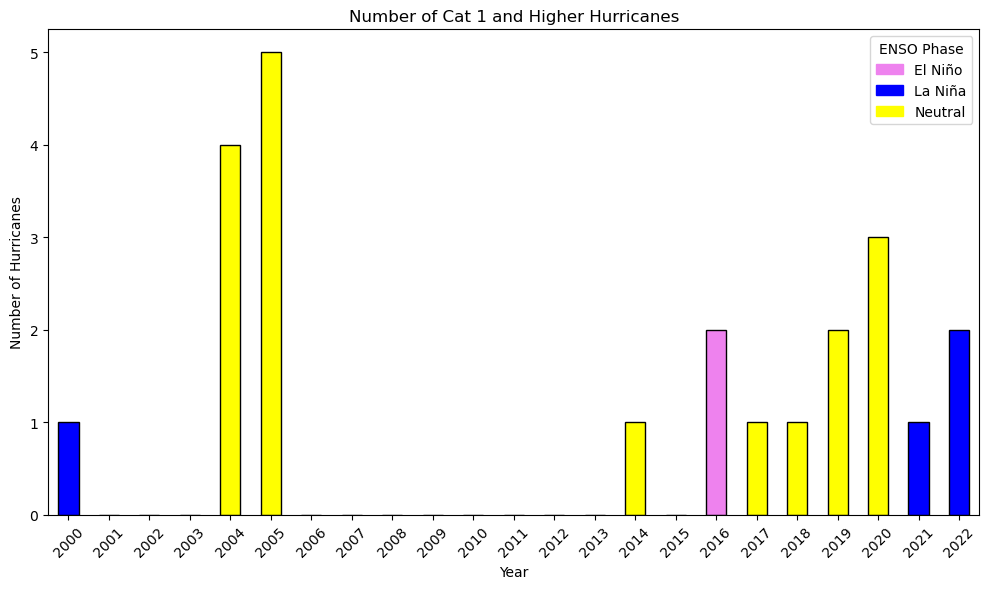

In [11]:
# Group by year and count unique storm names
storm_counts = df2.groupby('Year')['Name'].nunique()

# Create a range of years
all_years = pd.Series(range(df2['Year'].min(), df2['Year'].max() + 1), name='Year')

# Fill in missing years with 0
storm_counts = storm_counts.reindex(all_years, fill_value=0)

# Create a color map based on ENSO phases
enso_colors = {
    'El Niño': 'violet',
    'La Niña': 'blue',
    'Neutral': 'yellow'
}

# Map colors to the years based on ENSO phases
colors = df2.drop_duplicates('Year').set_index('Year')['ENSO'].reindex(all_years).map(enso_colors)

# Replace NaN values in colors with a default color (e.g., gray)
colors = colors.fillna('gray')

# Plot the data
plt.figure(figsize=(10, 6))
storm_counts.plot(kind='bar', color=colors, edgecolor='black')
# Label stuff
plt.xlabel('Year')
plt.ylabel('Number of Hurricanes')
plt.title('Number of Cat 1 and Higher Hurricanes')
plt.xticks(rotation=45)

# Add legend for colors
handles = [plt.Rectangle((0,0),1,1, color=color) for color in enso_colors.values()]
labels = enso_colors.keys()
plt.legend(handles, labels, title="ENSO Phase")

plt.tight_layout()
plt.show()

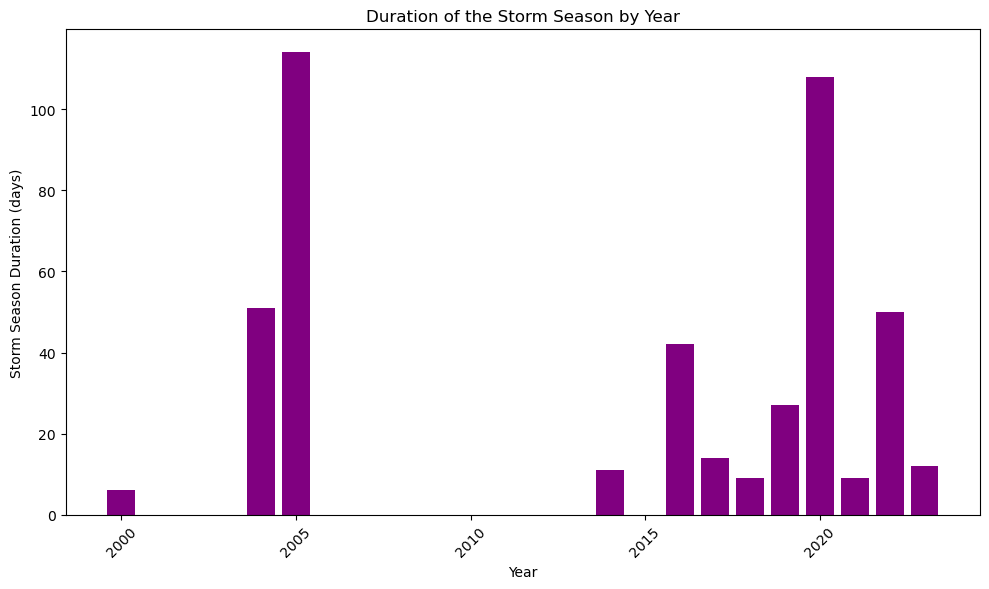

In [16]:
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])

# Group by year
season_durations = df.groupby('Year')['ISO_TIME'].agg(['min', 'max'])
season_durations['Duration'] = (season_durations['max'] - season_durations['min']).dt.days

# Plot the duration of the storm season for each year
plt.figure(figsize=(10, 6))
plt.bar(season_durations.index, season_durations['Duration'], color='purple')
plt.xlabel('Year')
plt.ylabel('Storm Season Duration (days)')
plt.title('Duration of the Storm Season by Year')
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

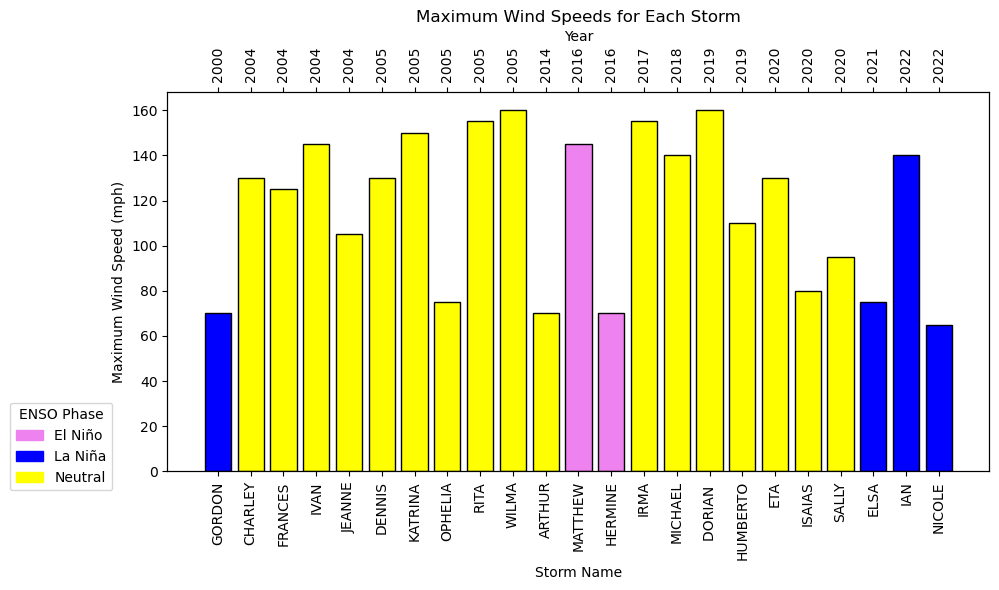

In [17]:
# Group by storm name and get the maximum wind speed for each storm
max_wind_speeds = df2.groupby(['Year', 'Name'])['WMO WIND'].max().reset_index()

# Sort by year
max_wind_speeds = max_wind_speeds.sort_values(by='Year')

# Create a color map based on ENSO phases
enso_colors = {
    'El Niño': 'violet',
    'La Niña': 'blue',
    'Neutral': 'yellow'
}

# Map colors to the years based on ENSO phases
colors = df2.drop_duplicates('Year').set_index('Year')['ENSO'].map(enso_colors)

# Replace NaN values in colors with a default color (e.g., gray)
colors = colors.fillna('gray')

# Ensure the colors Series is aligned with the max_wind_speeds index
colors = colors.reindex(max_wind_speeds['Year']).values

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the maximum wind speeds
bars = ax1.bar(max_wind_speeds['Name'], max_wind_speeds['WMO WIND'], color=colors, edgecolor='black')

# Label stuff for the first axis
ax1.set_xlabel('Storm Name')
ax1.set_ylabel('Maximum Wind Speed (mph)')
ax1.set_title('Maximum Wind Speeds for Each Storm')
ax1.tick_params(axis='x', rotation=90)

# Add legend for colors
handles = [plt.Rectangle((0,0),1,1, color=color) for color in enso_colors.values()]
labels = enso_colors.keys()
plt.legend(handles, labels, title="ENSO Phase", loc='upper left', bbox_to_anchor=(-0.2, 0.2))

# Create a second x-axis to show the year labels
ax2 = ax1.twiny()

# Set the second x-axis limits to match the first x-axis
ax2.set_xlim(ax1.get_xlim())

# Set the second x-axis ticks and labels to show the years
ax2.set_xticks(range(len(max_wind_speeds)))
ax2.set_xticklabels(max_wind_speeds['Year'], rotation=90)

# Set the second x-axis label
ax2.set_xlabel('Year')

plt.tight_layout()
plt.show()

In [18]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [19]:
nans_in_columns = df2.isna().sum()
print(nans_in_columns)

Year           0
Name           0
BASIN       2136
ISO_TIME       0
NATURE         0
LAT            0
LON            0
WMO WIND    1010
WMO PRES    1010
USA WIND       0
USA PRES       0
ENSO           0
dtype: int64


In [48]:
df2 = df2.drop(columns=['BASIN'])

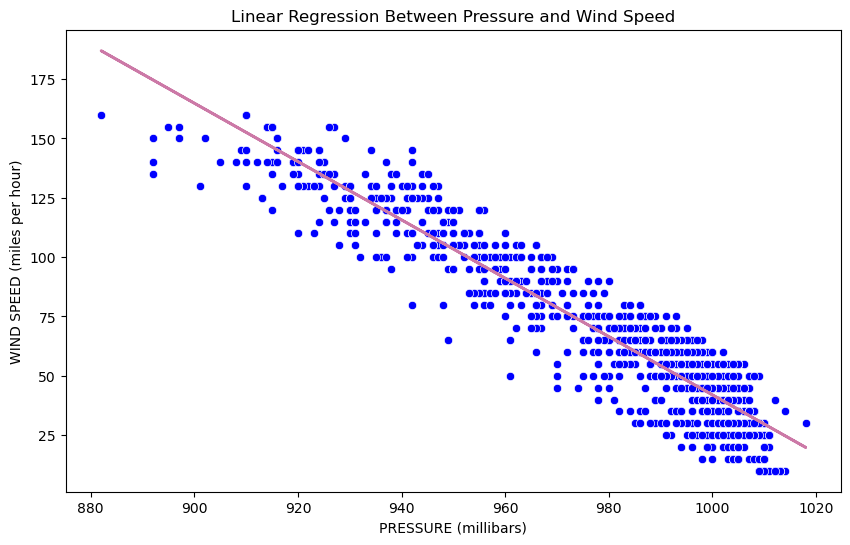

In [39]:
### Linear Regression of Pressure and Wind

# Drop rows with NaN values
df3 = df2.dropna(subset=['WMO WIND', 'WMO PRES'])

# Extract the relevant columns
X = df3[['WMO PRES']]
y = df3['WMO WIND']

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict values
y_pred = model.predict(X)

# Plot the data and the regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='WMO PRES', y='WMO WIND', data=df3, color='blue')
plt.plot(df3['WMO PRES'], y_pred, color='#cc79a7', linewidth=2)
plt.xlabel('PRESSURE (millibars)')
plt.ylabel('WIND SPEED (miles per hour)')
plt.title('Linear Regression Between Pressure and Wind Speed')
plt.show()
